<a href="https://colab.research.google.com/github/ester0926/Deep-Generative-Models/blob/main/%E4%BD%9C%E6%A5%AD5_LLM_Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets transformers peft accelerate evaluate bitsandbytes scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.3 MB/s eta 0:00:00


In [ ]:
# 載入套件
from datasets import load_dataset
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    pipeline,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import evaluate
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 作業設定
# 模型選擇（符合作業要求：TinyLlama、LLaMA、Qwen、Mistral）
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # 1.1B，適合免費 Colab

# 資料集設定
MAX_LENGTH = 128
TRAIN_SAMPLES = 2000  # 從 16,000 中選取
VAL_SAMPLES = 500     # 從 2,000 中選取
TEST_SAMPLES = 500    # 從 2,000 中選取

# 風險標註（Risk Mapping）
LABEL_TO_EMOTION = {
    0: "sadness", 1: "joy", 2: "love",
    3: "anger", 4: "fear", 5: "surprise"
}

# joy/love/surprise → 0 = low_risk
# anger/fear → 1 = mid_risk
# sadness → 2 = high_risk
EMOTION_TO_RISK = {
    "joy": 0, "love": 0, "surprise": 0,
    "anger": 1, "fear": 1,
    "sadness": 2
}

EMOTIONS_LIST = ["sadness", "joy", "love", "anger", "fear", "surprise"]

print(f"✅ 使用模型: {MODEL_NAME}")
print(f"✅ 訓練樣本: {TRAIN_SAMPLES} | 驗證樣本: {VAL_SAMPLES} | 測試樣本: {TEST_SAMPLES}")

✅ 使用模型: TinyLlama/TinyLlama-1.1B-Chat-v1.0
✅ 訓練樣本: 2000 | 驗證樣本: 500 | 測試樣本: 500


In [ ]:
# 資料載入
dataset = load_dataset("dair-ai/emotion")

# 建立風險映射
def map_to_risk(example):
    emotion_name = LABEL_TO_EMOTION[example["label"]]
    example["risk"] = EMOTION_TO_RISK[emotion_name]
    return example

dataset = dataset.map(map_to_risk)

print(f"\n資料集統計:")
print(f"  訓練集: {len(dataset['train'])} 筆")
print(f"  驗證集: {len(dataset['validation'])} 筆")
print(f"  測試集: {len(dataset['test'])} 筆")

# 情緒標籤分布
print(f"\n情緒標籤分布:")
emotion_counts = pd.Series([ex['label'] for ex in dataset['train']]).value_counts().sort_index()
for label_id, count in emotion_counts.items():
    emotion = LABEL_TO_EMOTION[label_id]
    risk = EMOTION_TO_RISK[emotion]
    print(f"  {emotion:10s} (risk={risk}): {count:5d} 筆")

# 準備測試集
test_data = dataset["test"].select(range(TEST_SAMPLES))
test_texts = [ex["text"] for ex in test_data]
test_labels = [ex["label"] for ex in test_data]

print(f"\n範例文本:")
for i in range(3):
    sample = dataset['train'][i]
    emotion = LABEL_TO_EMOTION[sample['label']]
    risk = EMOTION_TO_RISK[emotion]
    print(f"  [{emotion}, risk={risk}] {sample['text'][:60]}...")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]


資料集統計:
  訓練集: 16000 筆
  驗證集: 2000 筆
  測試集: 2000 筆

情緒標籤分布:
  sadness    (risk=2):  4666 筆
  joy        (risk=0):  5362 筆
  love       (risk=0):  1304 筆
  anger      (risk=1):  2159 筆
  fear       (risk=1):  1937 筆
  surprise   (risk=0):   572 筆

範例文本:
  [sadness, risk=2] i didnt feel humiliated...
  [sadness, risk=2] i can go from feeling so hopeless to so damned hopeful just ...
  [anger, risk=1] im grabbing a minute to post i feel greedy wrong...


In [ ]:
# 輔助函數
def show_examples(texts, true_labels, predictions, method_name, n=10):
    """顯示預測範例"""
    print(f"\n{'='*80}")
    print(f"{method_name} - 預測範例 (前 {n} 個)")
    print(f"{'='*80}")
    print(f"{'No.':<4} {'True':<12} {'Pred':<12} {'Match':<6} {'Text':<50}")
    print("-" * 80)

    for i in range(min(n, len(texts))):
        true_emotion = LABEL_TO_EMOTION[true_labels[i]]
        pred_emotion = LABEL_TO_EMOTION[predictions[i]]
        match = "✓" if true_emotion == pred_emotion else "✗"
        text_preview = texts[i][:47] + "..." if len(texts[i]) > 47 else texts[i]

        print(f"{i+1:<4} {true_emotion:<12} {pred_emotion:<12} {match:<6} {text_preview}")

def calculate_metrics(y_true, y_pred, method_name):
    """計算評估指標"""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"\n【{method_name} 評估指標】")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score (weighted): {f1:.4f}")

    # 計算 AUROC (多分類 one-vs-rest)
    try:
        y_true_onehot = pd.get_dummies(y_true).values
        y_pred_onehot = pd.get_dummies(y_pred).values
        auroc = roc_auc_score(y_true_onehot, y_pred_onehot, average="weighted", multi_class="ovr")
        print(f"  AUROC (weighted): {auroc:.4f}")
    except:
        print(f"  AUROC: N/A (無法計算)")

    return {"accuracy": acc, "f1": f1}

In [ ]:
# 方法 1: Zero-shot
print("\n" + "="*80)
print("【方法 1: Zero-shot 推論】")
print("="*80)

print("\n載入 TinyLlama 模型...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

generator = pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    device_map="auto",
    torch_dtype=torch.float16,
)

def zero_shot_predict(text, generator):
    """Zero-shot 情緒分類"""
    prompt = f"""<|system|>
You are an emotion classifier. Classify the text into one of these emotions: sadness, joy, love, anger, fear, surprise.
<|user|>
Text: "{text}"
Emotion:<|assistant|>
"""

    try:
        result = generator(
            prompt,
            max_new_tokens=10,
            temperature=0.3,
            do_sample=True,
            return_full_text=False,
            pad_token_id=tokenizer.eos_token_id
        )[0]["generated_text"]

        result_lower = result.lower().strip()

        for emotion in EMOTIONS_LIST:
            if emotion in result_lower:
                return emotion

        # Fallback: 關鍵字匹配
        text_lower = text.lower()
        if any(word in text_lower for word in ["hate", "angry", "mad"]):
            return "anger"
        elif any(word in text_lower for word in ["happy", "glad", "excited"]):
            return "joy"
        elif any(word in text_lower for word in ["sad", "depressed", "down"]):
            return "sadness"
        elif any(word in text_lower for word in ["love", "adore"]):
            return "love"
        elif any(word in text_lower for word in ["fear", "scared", "afraid"]):
            return "fear"
        else:
            return "surprise"

    except:
        return "joy"

print("\n開始 Zero-shot 預測...")
zero_shot_predictions = []
for text in tqdm(test_texts, desc="Zero-shot"):
    pred = zero_shot_predict(text, generator)
    if pred not in EMOTIONS_LIST:
        pred = "joy"
    pred_label = [k for k, v in LABEL_TO_EMOTION.items() if v == pred][0]
    zero_shot_predictions.append(pred_label)

zero_results = calculate_metrics(test_labels, zero_shot_predictions, "Zero-shot")
show_examples(test_texts, test_labels, zero_shot_predictions, "Zero-shot", n=10)

# 釋放記憶體
del generator
gc.collect()
torch.cuda.empty_cache()


【方法 1: Zero-shot 推論】

載入 TinyLlama 模型...


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0



開始 Zero-shot 預測...


Zero-shot: 100%|██████████| 500/500 [02:36<00:00,  3.19it/s]



【Zero-shot 評估指標】
  Accuracy: 0.2500
  F1 Score (weighted): 0.3091
  AUROC (weighted): 0.5773

Zero-shot - 預測範例 (前 10 個)
No.  True         Pred         Match  Text                                              
--------------------------------------------------------------------------------
1    sadness      sadness      ✓      im feeling rather rotten so im not very ambitio...
2    sadness      surprise     ✗      im updating my blog because i feel shitty
3    sadness      surprise     ✗      i never make her separate from me because i don...
4    joy          surprise     ✗      i left with my bouquet of red and yellow tulips...
5    sadness      joy          ✗      i was feeling a little vain when i did this one
6    fear         sadness      ✗      i cant walk into a shop anywhere where i do not...
7    anger        anger        ✓      i felt anger when at the end of a telephone cal...
8    joy          surprise     ✗      i explain why i clung to a relationship with a ...
9    joy 

In [ ]:
# 方法 2: Few-shot
print("\n" + "="*80)
print("【方法 2: Few-shot 推論】")
print("="*80)

print("\n重新載入模型...")
generator = pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    device_map="auto",
    torch_dtype=torch.float16,
)

def few_shot_predict(text, generator):
    prompt = f"""Classify emotions:

"I'm so happy!" → joy
"I feel empty." → sadness
"I love this!" → love

"{text}" →"""

    try:
        result = generator(
            prompt,
            max_new_tokens=2,      # ← 只需 1-2 個 token
            temperature=0.01,       # ← 幾乎沒有隨機性
            do_sample=False,        # ← 完全確定性
            return_full_text=False,
            pad_token_id=tokenizer.eos_token_id
        )[0]["generated_text"]

        result_lower = result.lower().strip()

        for emotion in EMOTIONS_LIST:
            if emotion in result_lower:
                return emotion

        # Fallback
        # ... (同之前)

    except:
        return "joy"

print("\n開始 Few-shot 預測...")
few_shot_predictions = []
for text in tqdm(test_texts, desc="Few-shot"):
    pred = few_shot_predict(text, generator)
    if pred not in EMOTIONS_LIST:
        pred = "joy"
    pred_label = [k for k, v in LABEL_TO_EMOTION.items() if v == pred][0]
    few_shot_predictions.append(pred_label)

few_results = calculate_metrics(test_labels, few_shot_predictions, "Few-shot")
show_examples(test_texts, test_labels, few_shot_predictions, "Few-shot", n=10)

# 釋放記憶體
del generator
gc.collect()
torch.cuda.empty_cache()


【方法 2: Few-shot 推論】

重新載入模型...


Device set to use cuda:0



開始 Few-shot 預測...


Few-shot: 100%|██████████| 500/500 [00:34<00:00, 14.54it/s]



【Few-shot 評估指標】
  Accuracy: 0.4480
  F1 Score (weighted): 0.3875
  AUROC (weighted): 0.6271

Few-shot - 預測範例 (前 10 個)
No.  True         Pred         Match  Text                                              
--------------------------------------------------------------------------------
1    sadness      sadness      ✓      im feeling rather rotten so im not very ambitio...
2    sadness      anger        ✗      im updating my blog because i feel shitty
3    sadness      joy          ✗      i never make her separate from me because i don...
4    joy          joy          ✓      i left with my bouquet of red and yellow tulips...
5    sadness      joy          ✗      i was feeling a little vain when i did this one
6    fear         joy          ✗      i cant walk into a shop anywhere where i do not...
7    anger        anger        ✓      i felt anger when at the end of a telephone cal...
8    joy          anger        ✗      i explain why i clung to a relationship with a ...
9    joy   

In [ ]:
# 方法 3: LoRA Fine-tuning
print("\n" + "="*80)
print("【方法 3: LoRA 微調】")
print("="*80)

print("\n載入分類模型...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=6,
    torch_dtype=torch.float16,
    device_map="auto"
)

# LoRA 配置
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

print("\n模型參數統計:")
model.print_trainable_parameters()

# 資料預處理
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

print("\n預處理資料...")
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["text", "risk"]
)

train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(TRAIN_SAMPLES))
val_dataset = tokenized_datasets["validation"].select(range(VAL_SAMPLES))
test_dataset = tokenized_datasets["test"].select(range(TEST_SAMPLES))

# 訓練設定
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-4,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    fp16=True,
)

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("\n開始訓練...")
trainer.train()

# 評估
print("\n評估 LoRA 模型...")
predictions = trainer.predict(test_dataset)
lora_predictions = np.argmax(predictions.predictions, axis=1)

lora_results = calculate_metrics(test_labels, lora_predictions, "LoRA Fine-tuning")
show_examples(test_texts, test_labels, lora_predictions, "LoRA", n=10)

`torch_dtype` is deprecated! Use `dtype` instead!



【方法 3: LoRA 微調】

載入分類模型...


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



模型參數統計:
trainable params: 1,138,688 || all params: 1,035,663,360 || trainable%: 0.1099

預處理資料...


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.



開始訓練...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.850000,0.797481,0.784000,0.779386
2,0.554600,0.463641,0.858000,0.856297
3,0.283600,0.504771,0.886000,0.885059



評估 LoRA 模型...



【LoRA Fine-tuning 評估指標】
  Accuracy: 0.8880
  F1 Score (weighted): 0.8879
  AUROC (weighted): 0.9289

LoRA - 預測範例 (前 10 個)
No.  True         Pred         Match  Text                                              
--------------------------------------------------------------------------------
1    sadness      joy          ✗      im feeling rather rotten so im not very ambitio...
2    sadness      sadness      ✓      im updating my blog because i feel shitty
3    sadness      sadness      ✓      i never make her separate from me because i don...
4    joy          joy          ✓      i left with my bouquet of red and yellow tulips...
5    sadness      sadness      ✓      i was feeling a little vain when i did this one
6    fear         fear         ✓      i cant walk into a shop anywhere where i do not...
7    anger        anger        ✓      i felt anger when at the end of a telephone cal...
8    joy          sadness      ✗      i explain why i clung to a relationship with a ...
9    jo

In [ ]:
# 三種方法比較
print("\n" + "="*80)
print("【三種方法性能比較】")
print("="*80)

results_df = pd.DataFrame({
    "Method": ["Zero-shot", "Few-shot", "LoRA Fine-tuning"],
    "Accuracy": [
        zero_results["accuracy"],
        few_results["accuracy"],
        lora_results["accuracy"]
    ],
    "F1 Score": [
        zero_results["f1"],
        few_results["f1"],
        lora_results["f1"]
    ]
})

print("\n" + results_df.to_string(index=False))

print(f"\n改進幅度:")
print(f"  Few-shot vs Zero-shot: {(few_results['f1'] - zero_results['f1'])/zero_results['f1']*100:+.1f}%")
print(f"  LoRA vs Few-shot: {(lora_results['f1'] - few_results['f1'])/few_results['f1']*100:+.1f}%")
print(f"  LoRA vs Zero-shot: {(lora_results['f1'] - zero_results['f1'])/zero_results['f1']*100:+.1f}%")

# 詳細分類報告
print("\n【詳細分類報告】")
for name, preds in [("Zero-shot", zero_shot_predictions),
                     ("Few-shot", few_shot_predictions),
                     ("LoRA", lora_predictions)]:
    print(f"\n{name}:")
    print(classification_report(test_labels, preds, target_names=EMOTIONS_LIST, digits=4))


【三種方法性能比較】

          Method  Accuracy  F1 Score
       Zero-shot     0.250  0.309119
        Few-shot     0.448  0.387470
LoRA Fine-tuning     0.888  0.887877

改進幅度:
  Few-shot vs Zero-shot: +25.3%
  LoRA vs Few-shot: +129.1%
  LoRA vs Zero-shot: +187.2%

【詳細分類報告】

Zero-shot:
              precision    recall  f1-score   support

     sadness     0.4112    0.2973    0.3451       148
         joy     0.6724    0.2583    0.3732       151
        love     0.1667    0.1026    0.1270        39
       anger     0.4894    0.2911    0.3651        79
        fear     0.8750    0.1000    0.1795        70
    surprise     0.0312    0.6154    0.0595        13

    accuracy                         0.2500       500
   macro avg     0.4410    0.2774    0.2416       500
weighted avg     0.5384    0.2500    0.3091       500


Few-shot:
              precision    recall  f1-score   support

     sadness     0.7097    0.1486    0.2458       148
         joy     0.4188    0.8543    0.5621       151
    


【評估與視覺化】


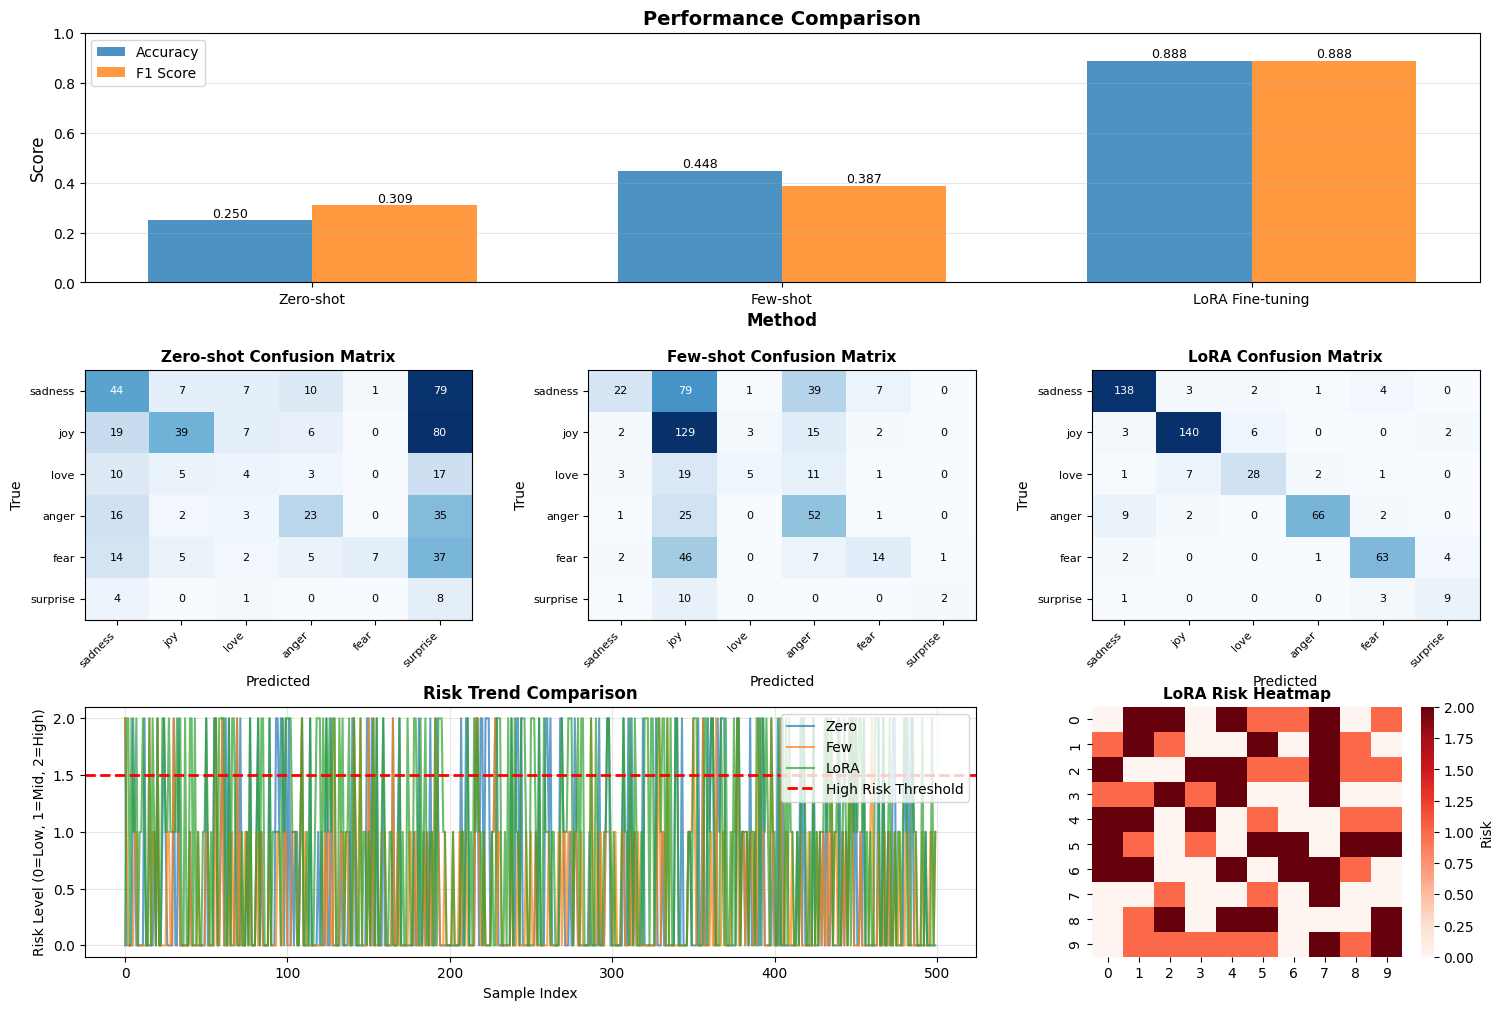

In [ ]:
# 視覺化比較
print("\n" + "="*80)
print("【評估與視覺化】")
print("="*80)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. 性能比較
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(results_df))
width = 0.35
bars1 = ax1.bar(x - width/2, results_df["Accuracy"], width, label='Accuracy', alpha=0.8)
bars2 = ax1.bar(x + width/2, results_df["F1 Score"], width, label='F1 Score', alpha=0.8)
ax1.set_xlabel('Method', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df["Method"])
ax1.legend()
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2-4. 混淆矩陣
for idx, (name, preds, pos) in enumerate([
    ("Zero-shot", zero_shot_predictions, gs[1, 0]),
    ("Few-shot", few_shot_predictions, gs[1, 1]),
    ("LoRA", lora_predictions, gs[1, 2])
]):
    ax = fig.add_subplot(pos)
    cm = confusion_matrix(test_labels, preds)
    im = ax.imshow(cm, cmap='Blues', aspect='auto')
    ax.set_xticks(np.arange(6))
    ax.set_yticks(np.arange(6))
    ax.set_xticklabels(EMOTIONS_LIST, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(EMOTIONS_LIST, fontsize=8)

    for i in range(6):
        for j in range(6):
            ax.text(j, i, f'{cm[i, j]}', ha="center", va="center",
                   color="white" if cm[i, j] > cm.max()/2 else "black", fontsize=8)

    ax.set_title(f'{name} Confusion Matrix', fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# 5-6. 風險分析
ax5 = fig.add_subplot(gs[2, :2])

risk_scores = {}
for name, preds in [("Zero", zero_shot_predictions),
                     ("Few", few_shot_predictions),
                     ("LoRA", lora_predictions)]:
    risks = [EMOTION_TO_RISK[LABEL_TO_EMOTION[p]] for p in preds]
    risk_scores[name] = risks
    ax5.plot(risks, label=name, alpha=0.7, linewidth=1.5)

ax5.axhline(y=1.5, color='red', linestyle='--', linewidth=2, label='High Risk Threshold')
ax5.set_title('Risk Trend Comparison', fontsize=12, fontweight='bold')
ax5.set_xlabel('Sample Index')
ax5.set_ylabel('Risk Level (0=Low, 1=Mid, 2=High)')
ax5.legend()
ax5.grid(alpha=0.3)

# 7. 熱力圖
ax6 = fig.add_subplot(gs[2, 2])
lora_risks = risk_scores["LoRA"]
if len(lora_risks) >= 100:
    rows, cols = 10, 10
    risk_matrix = np.array(lora_risks[:rows*cols]).reshape(rows, cols)
    sns.heatmap(risk_matrix, cmap="Reds", cbar_kws={'label': 'Risk'}, ax=ax6, vmin=0, vmax=2)
    ax6.set_title('LoRA Risk Heatmap', fontsize=11, fontweight='bold')

plt.savefig('hw5_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# 憂鬱風險分析比較
print("\n【風險監測統計】")

true_risks = [EMOTION_TO_RISK[LABEL_TO_EMOTION[l]] for l in test_labels]

for name, preds in [("Zero-shot", zero_shot_predictions),
                     ("Few-shot", few_shot_predictions),
                     ("LoRA", lora_predictions)]:
    pred_risks = [EMOTION_TO_RISK[LABEL_TO_EMOTION[p]] for p in preds]
    risk_acc = sum([1 for p, t in zip(pred_risks, true_risks) if p == t]) / len(pred_risks)

    print(f"\n{name}:")
    print(f"  風險分類準確率: {risk_acc*100:.2f}%")

    risk_counts = pd.Series(pred_risks).value_counts().sort_index()
    print(f"  低風險 (0): {risk_counts.get(0, 0)} 個")
    print(f"  中風險 (1): {risk_counts.get(1, 0)} 個")
    print(f"  高風險 (2): {risk_counts.get(2, 0)} 個")

print("\n" + "="*80)
print("✅ 作業完成！")
print("="*80)
print("\n生成檔案:")
print("  - hw5_results.png (完整評估圖表)")
print(f"\n最佳方法: LoRA Fine-tuning (F1: {lora_results['f1']:.4f})")


【風險監測統計】

Zero-shot:
  風險分類準確率: 48.00%
  低風險 (0): 338 個
  中風險 (1): 55 個
  高風險 (2): 107 個

Few-shot:
  風險分類準確率: 52.80%
  低風險 (0): 320 個
  中風險 (1): 149 個
  高風險 (2): 31 個

LoRA:
  風險分類準確率: 92.40%
  低風險 (0): 203 個
  中風險 (1): 143 個
  高風險 (2): 154 個

✅ 作業完成！

生成檔案:
  - hw5_results.png (完整評估圖表)

最佳方法: LoRA Fine-tuning (F1: 0.8879)
